In [4]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob

bg = None

In [3]:
# Starts capturing video
cap = cv2.VideoCapture(0)

fps = int(cap.get(cv2.CAP_PROP_FPS))

print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Captured Frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

    keypress = cv2.waitKey(1) & 0xFF

cap.release()
cv2.destroyAllWindows()

Frames per second using video.get(cv2.CAP_PROP_FPS) : 1


In [67]:
def run_avg(image, accumWeight):
    global bg
    # initialize the background
    if bg is None:
        bg = image.copy().astype("float")
        return

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, accumWeight)

def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# input shape
input_shape = (100, 120, 1)

# number of classes
num_classes = 6

# model
model = Sequential()

# first conv layer
model.add(Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third conv layer
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 120, 64)      1664      
                                                                 
 batch_normalization_5 (Batc  (None, 100, 120, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 60, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 50, 60, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 60, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 50, 60, 128)     

In [5]:
# Loading the Dataset

DATASET_PATH = 'data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['data/ok',
 'data/thumbsup',
 'data/blank',
 'data/thumbsdown',
 'data/fist',
 'data/five']

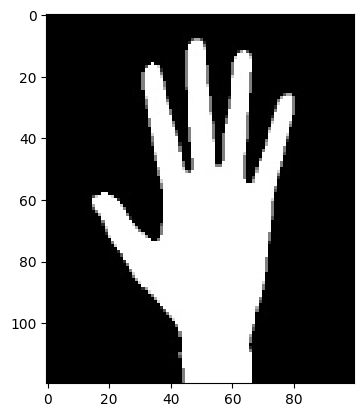

In [6]:
import cv2
image = cv2.imread('data/five/hand1(1015).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [7]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

9600
9600


In [8]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

(9600, 120, 100)
(9600, 6)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

(7680, 100, 120, 1)
(1920, 100, 120, 1)


In [15]:
# assuming x_train and y_train are your data
datagen.fit(X_train)

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              epochs = 2, validation_data = (X_test, y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // 32,
                              callbacks=[learning_rate_reduction])

model.save("hand_gesture_recognition_2.h5")

Epoch 1/2


2023-05-27 10:57:39.693922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


240/240 [==============================] - 187s 778ms/step - loss: 2.2223 - categorical_accuracy: 0.6342 - val_loss: 0.3777 - val_categorical_accuracy: 0.8302 - lr: 0.0010
Epoch 2/2
181/240 [=====================>........] - ETA: 47s - loss: 0.7128 - categorical_accuracy: 0.7291

KeyboardInterrupt: 

In [76]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))

60/60 [==============================] - 5s 78ms/step - loss: 0.0335 - categorical_accuracy: 0.9891
Accuracy: 0.989062488079071


In [127]:
# organize imports
import cv2
import imutils
import numpy as np
from sklearn.metrics import pairwise
from keras.models import load_model
from skimage.transform import resize
import tensorflow as tf

# global variables
bg = None


def run_avg(image, accumWeight):
    global bg
    # initialize the background
    if bg is None:
        bg = image.copy().astype("float")
        return

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, accumWeight)


def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)


def _load_weights():
    try:
        model = load_model("hand_gesture_recognition.h5")
        # print(model.summary())
        # print(model.get_weights())
        # print(model.optimizer)
        return model
    except Exception as e:
        return None


def getPredictedClass(model):
    image = cv2.imread('Temp.jpg')
    image = cv2.resize(image,(100, 120))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image,(100, 120))

    gray_image = gray_image.reshape(1, 100, 120, 1)

    # Predict the class
    predicted_class = np.argmax(model.predict_on_batch(gray_image), axis=1)

    if predicted_class == 0:
        return "Blank"
    elif predicted_class == 1:
        return "OK"
    elif predicted_class == 2:
        return "Thumbs Up"
    elif predicted_class == 3:
        return "Thumbs Down"
    elif predicted_class == 4:
        return "Punch"
    elif predicted_class == 5:
        return "High Five"



if __name__ == "__main__":
    # initialize accumulated weight
    accumWeight = 0.5

    # get the reference to the webcam
    camera = cv2.VideoCapture(0)

    fps = int(camera.get(cv2.CAP_PROP_FPS))
    # region of interest (ROI) coordinates
    top, right, bottom, left = 10, 350, 225, 590
    # initialize num of frames
    num_frames = 0
    # calibration indicator
    calibrated = False
    model = _load_weights()
    print("here")
    k = 0
    # keep looping, until interrupted
    while (True):
        # get the current frame
        (grabbed, frame) = camera.read()

        # resize the frame
        frame = imutils.resize(frame, width=700)
        # flip the frame so that it is not the mirror view
        frame = cv2.flip(frame, 1)

        # clone the frame
        clone = frame.copy()

        # get the height and width of the frame
        (height, width) = frame.shape[:2]

        # get the ROI
        roi = frame[top:bottom, right:left]

        # convert the roi to grayscale and blur it
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # to get the background, keep looking till a threshold is reached
        # so that our weighted average model gets calibrated
        if num_frames < 30:
            run_avg(gray, accumWeight)
            if num_frames == 1:
                print("[STATUS] please wait! calibrating...")
            elif num_frames == 29:
                print("[STATUS] calibration successfull...")
        else:
            # segment the hand region
            hand = segment(gray)
            # check whether hand region is segmented
            if hand is not None:
                
                # if yes, unpack the thresholded image and
                # segmented region
                (thresholded, segmented) = hand

                # draw the segmented region and display the frame
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))

                # count the number of fingers
                # fingers = count(thresholded, segmented)
                # if k % (fps / 6) == 0:
                cv2.imwrite('Temp.jpg', thresholded)
                predictedClass = getPredictedClass(model)
                cv2.putText(clone, str(predictedClass), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # show the thresholded image
                cv2.imshow("Thesholded", thresholded)
        k = k + 1
        # draw the segmented hand
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

        # increment the number of frames
        num_frames += 1

        # display the frame with segmented hand
        cv2.imshow("Video Feed", clone)

        # observe the keypress by the user
        keypress = cv2.waitKey(1) & 0xFF

        # if the user pressed "q", then stop looping
        if keypress == ord("q"):
            break

    # free up memory
    camera.release()
    cv2.destroyAllWindows()

here
[STATUS] please wait! calibrating...
[STATUS] calibration successfull...


2023-05-26 22:56:01.480761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [1,100,120,1]
	 [[{{node Placeholder/_0}}]]
2023-05-26 22:56:01.579208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [1,100,120,1]
	 [[{{node Placeholder/_0}}]]
2023-05-26 22:56:01.612441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and 

KeyboardInterrupt: 

In [130]:
def _load_weights():
    try:
        model = load_model("/Users/sina/Documents/GitHub/MindHomeProject/ECS171-Project/MLModel/hand_gesture_recognition.h5")
        # print(model.summary())
        # print(model.get_weights())
        # print(model.optimizer)
        return model
    except Exception as e:
        return None

def getPredictedClass(model):
    image = cv2.imread('out.png')
    image = cv2.resize(image,(100, 120))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image,(100, 120))

    gray_image = gray_image.reshape(1, 100, 120, 1)

    # Predict the class
    predicted_class = np.argmax(model.predict_on_batch(gray_image), axis=1)

    if predicted_class == 0:
        return "Blank"
    elif predicted_class == 1:
        return "OK"
    elif predicted_class == 2:
        return "Thumbs Up"
    elif predicted_class == 3:
        return "Thumbs Down"
    elif predicted_class == 4:
        return "Punch"
    elif predicted_class == 5:
        return "High Five"


# import cv2
# image = cv2.imread('Temp.jpg')
# image = cv2.resize(image,[100, 120])
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray_image = cv2.resize(gray_image,(100, 120))

# gray_image = gray_image.reshape(1, 100, 120, 1)
# gray_image.shape

# model = _load_weights()

# pred_idx = np.argmax(model.predict_on_batch(gray_image), axis=1)

# pred_idx
    
# image = cv2.imread('/Users/sina/Documents/GitHub/MindHomeProject/ECS171-Project/MLModel/data/fist/fistq2.jpg')
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image,(100, 120))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

model = _load_weights()

pred = getPredictedClass(model)
pred

2023-05-27 00:21:30.974178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [1,100,120,1]
	 [[{{node Placeholder/_0}}]]


'Punch'

: 